In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../scripts')

In [5]:
# Load the datasets
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

In [6]:
brent_oil_data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [7]:
brent_oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [8]:
brent_oil_data.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


(np.int64(0),
             Price
 Date             
 1987-05-20  18.63
 1987-05-21  18.45
 1987-05-22  18.55
 1987-05-25  18.60
 1987-05-26  18.63,
 <Axes: title={'center': 'Brent Oil Prices Over Time'}, xlabel='Date'>)

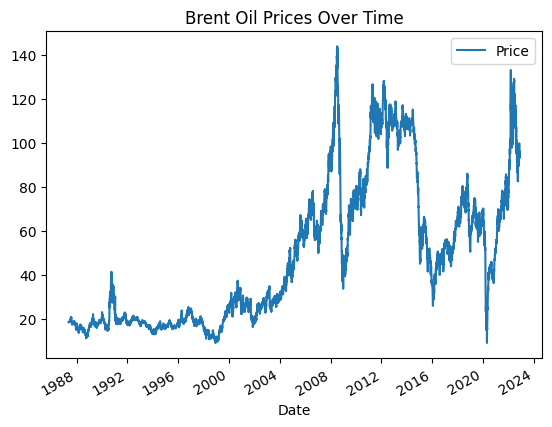

In [9]:
# Attempt to convert the 'Date' column to datetime, allowing for mixed date formats
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'], errors='coerce')

# Check for any conversion issues (NaT values)
missing_dates = brent_oil_data['Date'].isna().sum()

# Set 'Date' as index if all dates were parsed correctly
brent_oil_data.dropna(subset=['Date'], inplace=True)
brent_oil_data.set_index('Date', inplace=True)

# Display information about missing dates if any, and plot the data
missing_dates, brent_oil_data.head(), brent_oil_data.plot(y='Price', title='Brent Oil Prices Over Time')


In [11]:
print(brent_oil_data.index.dtype)  
print(brent_oil_data.index.is_monotonic_increasing)

datetime64[ns]
True


In [12]:
# Detect outliers using IQR method (we can use this for additional handling if needed)
Q1 = brent_oil_data['Price'].quantile(0.25)
Q3 = brent_oil_data['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((brent_oil_data['Price'] < (Q1 - 1.5 * IQR)) | (brent_oil_data['Price'] > (Q3 + 1.5 * IQR)))
print("Number of outliers detected:", outliers.sum())

Number of outliers detected: 0


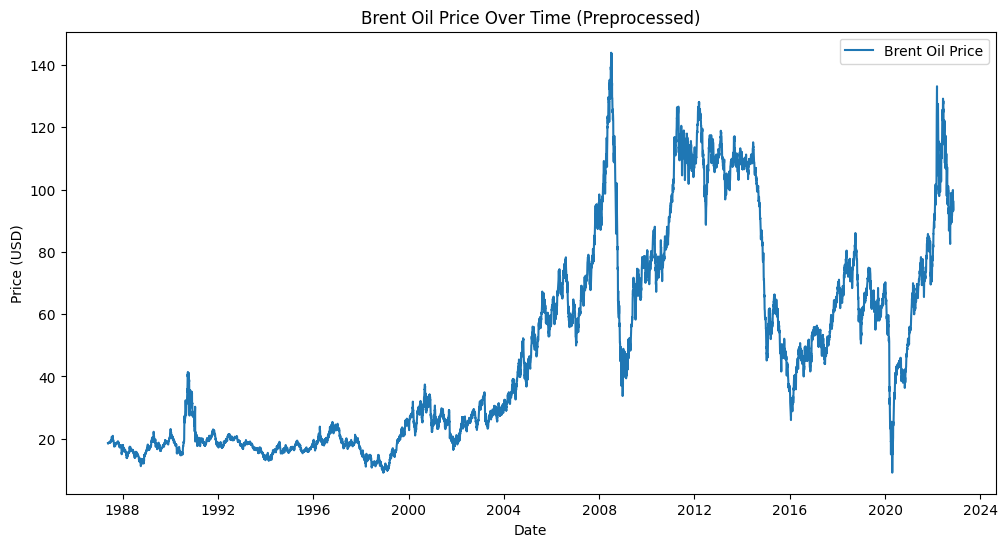

In [13]:
# Quick visualization to confirm preprocessing
plt.figure(figsize=(12, 6))
plt.plot(brent_oil_data['Price'], label='Brent Oil Price')
plt.title("Brent Oil Price Over Time (Preprocessed)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Exploratory Data Analysis (EDA)

In [17]:
# Check for any remaining missing values in the 'Price' column and obtain basic statistical insights.
missing_values = brent_oil_data.isnull().sum()
print("Descriptive Statistics for Brent Oil Prices:\n")
print(brent_oil_data['Price'].describe())

Descriptive Statistics for Brent Oil Prices:

count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64


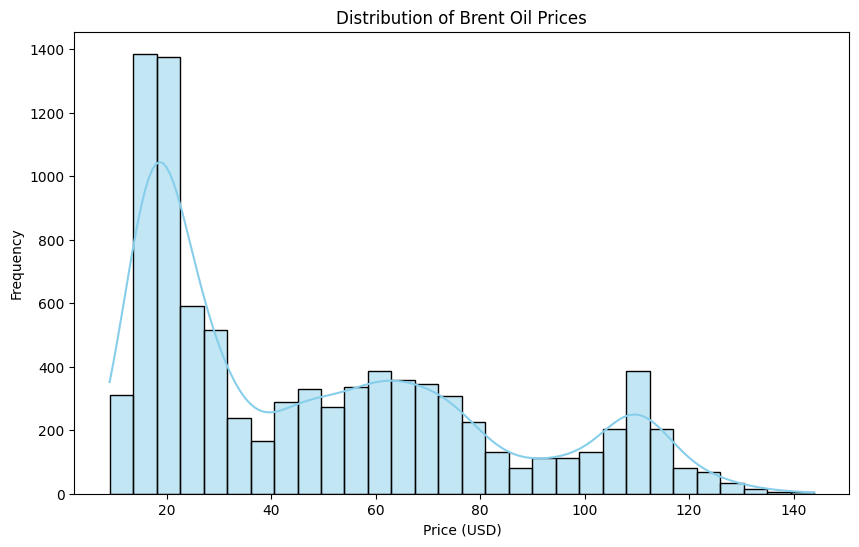

In [18]:
# Plot the distribution of Brent oil prices
plt.figure(figsize=(10, 6))
sns.histplot(brent_oil_data['Price'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Brent Oil Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.show()

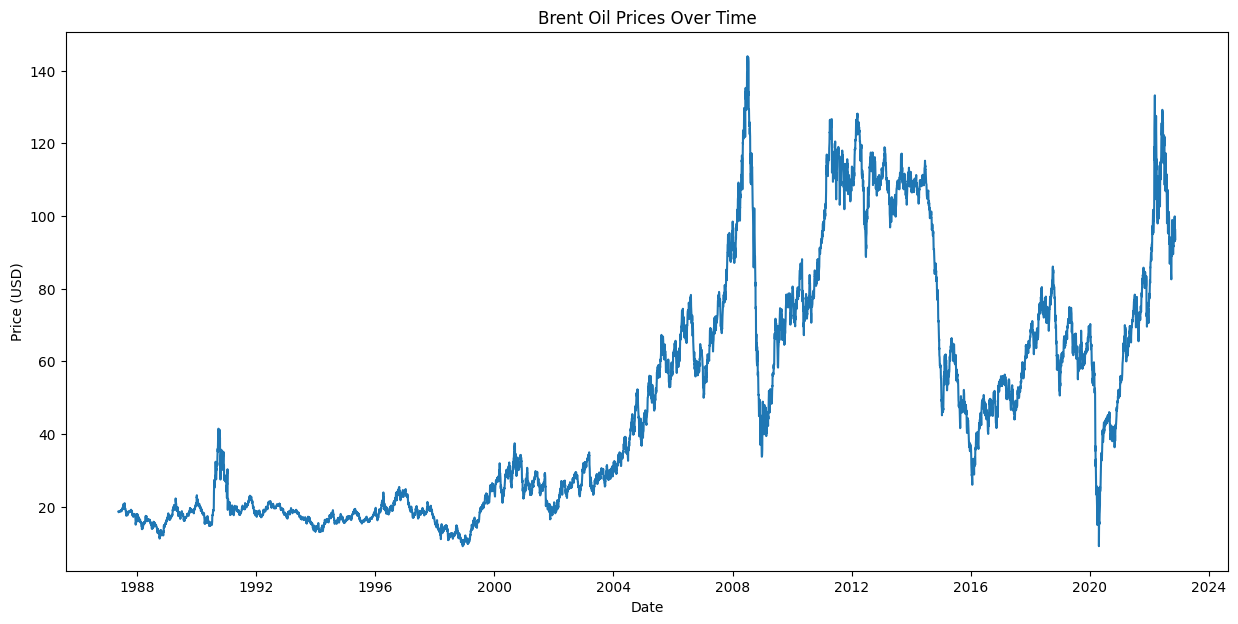

In [19]:
# Plot the time series to observe overall trends
plt.figure(figsize=(15, 7))
plt.plot(brent_oil_data.index, brent_oil_data['Price'])
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

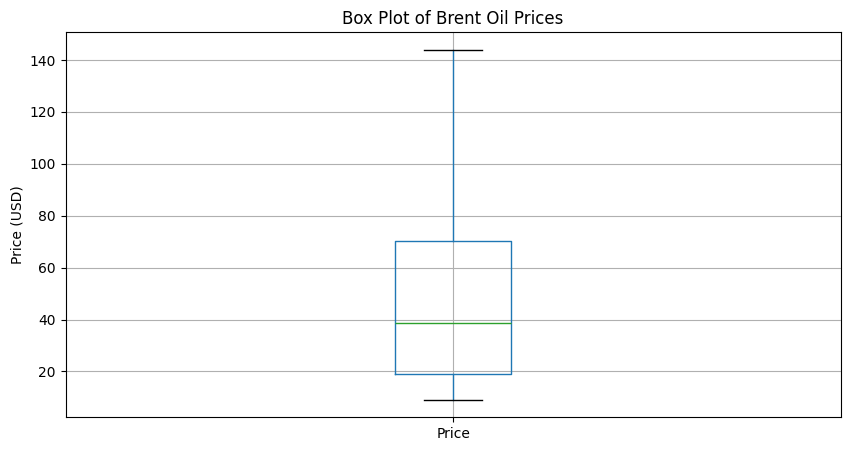

In [20]:
# Create box plot
plt.figure(figsize=(10, 5))
brent_oil_data.boxplot(column=['Price'])
plt.title('Box Plot of Brent Oil Prices')
plt.ylabel('Price (USD)')
plt.show()

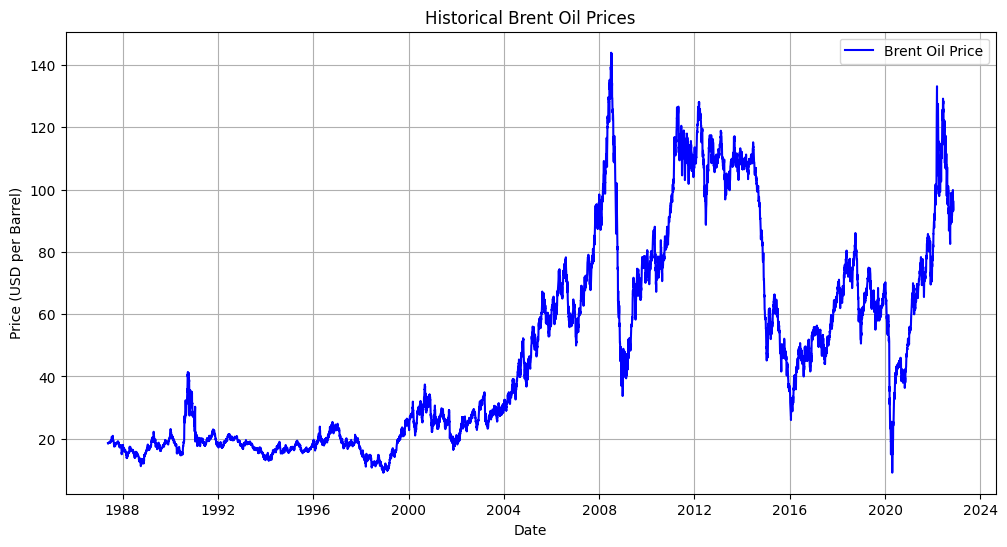

In [23]:
# Plotting the historical Brent oil prices
plt.figure(figsize=(12, 6))
plt.plot(brent_oil_data.index, brent_oil_data['Price'], label='Brent Oil Price', color='blue')
plt.title('Historical Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.grid()
plt.show()

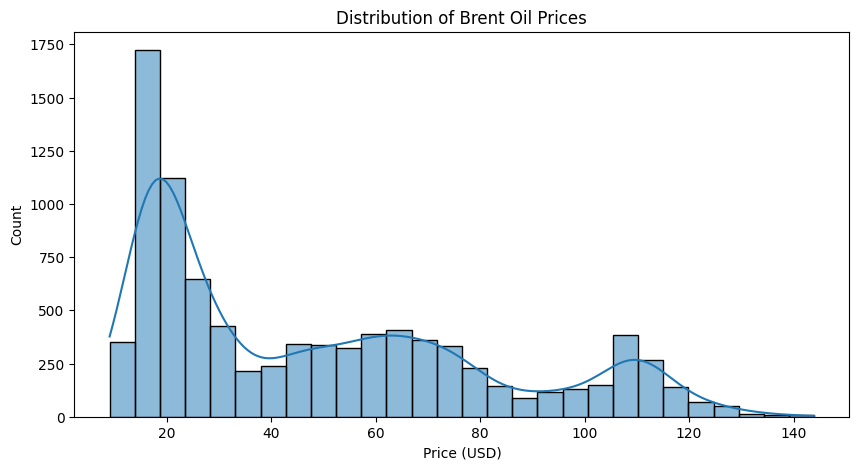

In [24]:
# Create a histogram of prices
plt.figure(figsize=(10, 5))
sns.histplot(brent_oil_data['Price'], kde=True)
plt.title('Distribution of Brent Oil Prices')
plt.xlabel('Price (USD)')
plt.show()

### Time Series Decomposition

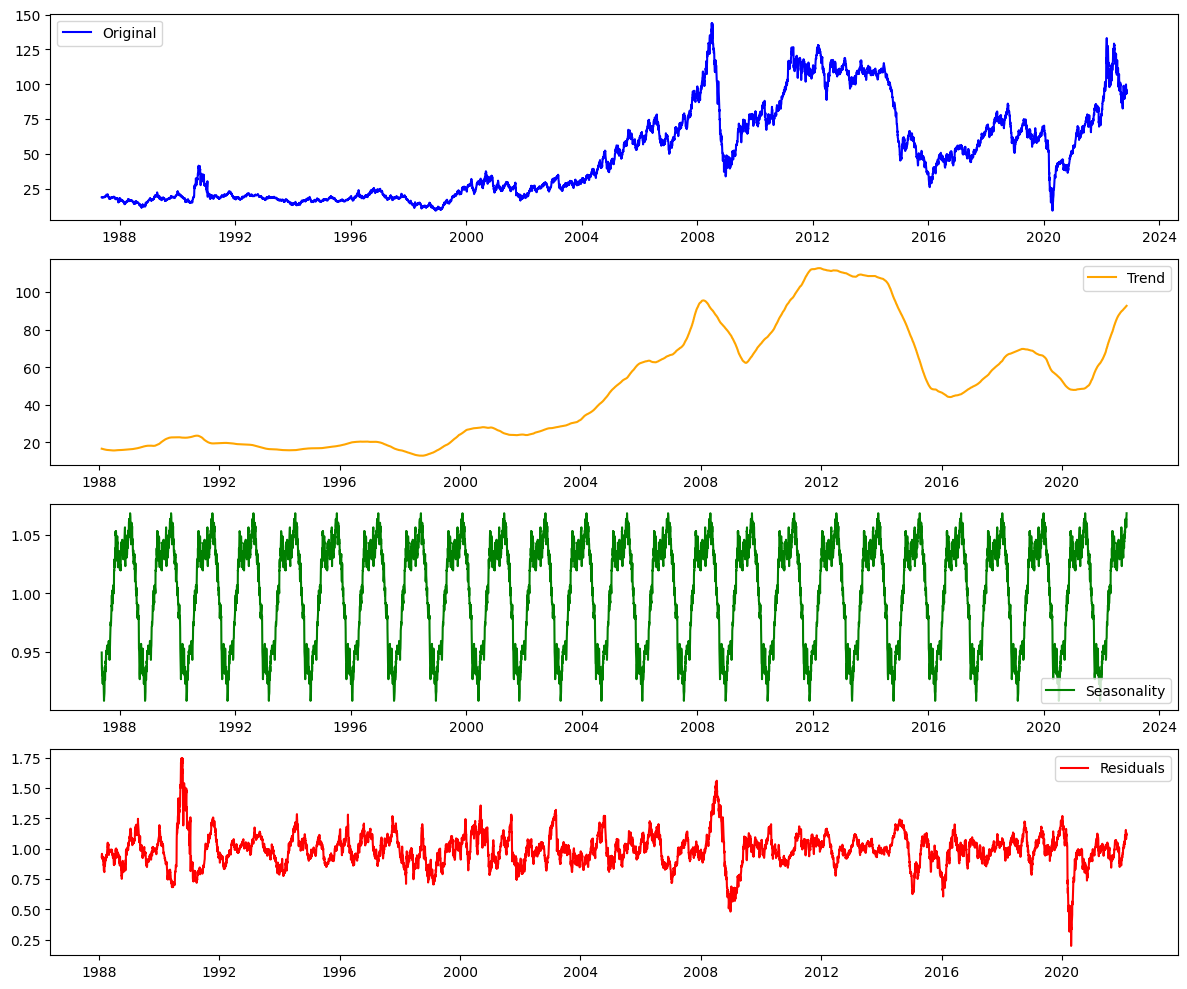

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
decomposition = seasonal_decompose(brent_oil_data['Price'], model='multiplicative', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition results
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(brent_oil_data['Price'], label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Change Point Detection

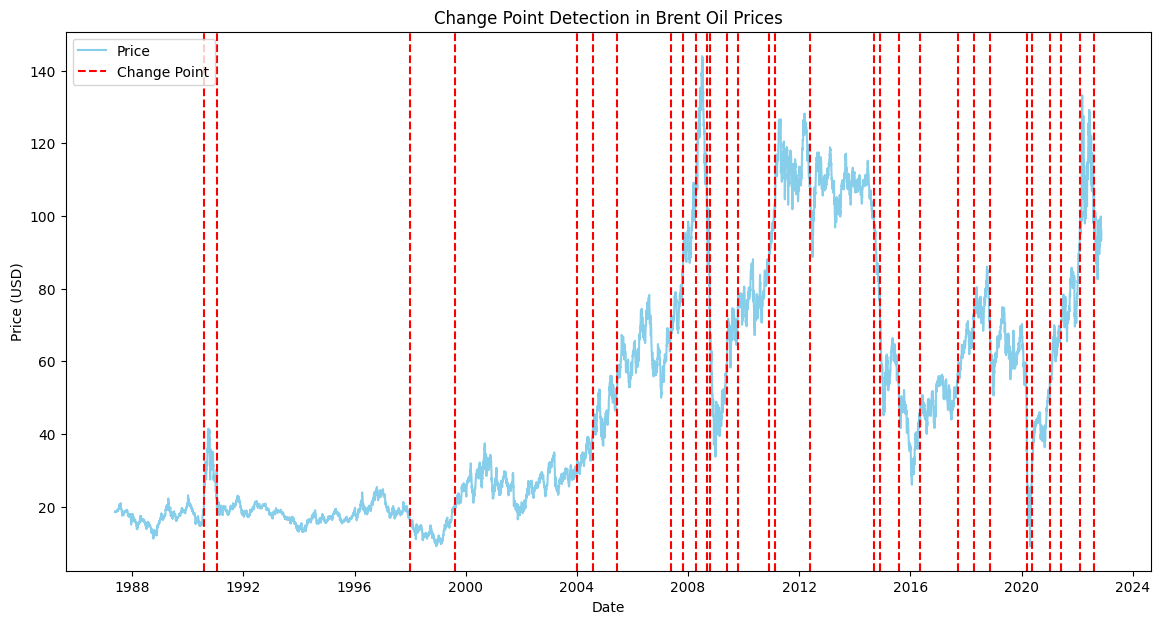

In [28]:
import ruptures as rpt
from ruptures import Pelt

# Selecting the data for change point detection
price_series = brent_oil_data['Price'].values

# Initialize and fit the change point detection model (e.g., Pelt method with a cost function)
model = rpt.Pelt(model="rbf").fit(price_series)

# Select penalty value to control the number of detected change points
penalty_value = 10  # you can adjust this value
change_points = model.predict(pen=penalty_value)

# Plot the change points detected
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Price'], label="Brent Oil Price", color="skyblue")
for cp in change_points[:-1]:  # Exclude the last index as it represents the end of the series
    plt.axvline(brent_oil_data.index[cp], color="red", linestyle="--")
plt.title("Change Point Detection in Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(["Price", "Change Point"])
plt.show()


### Key Events

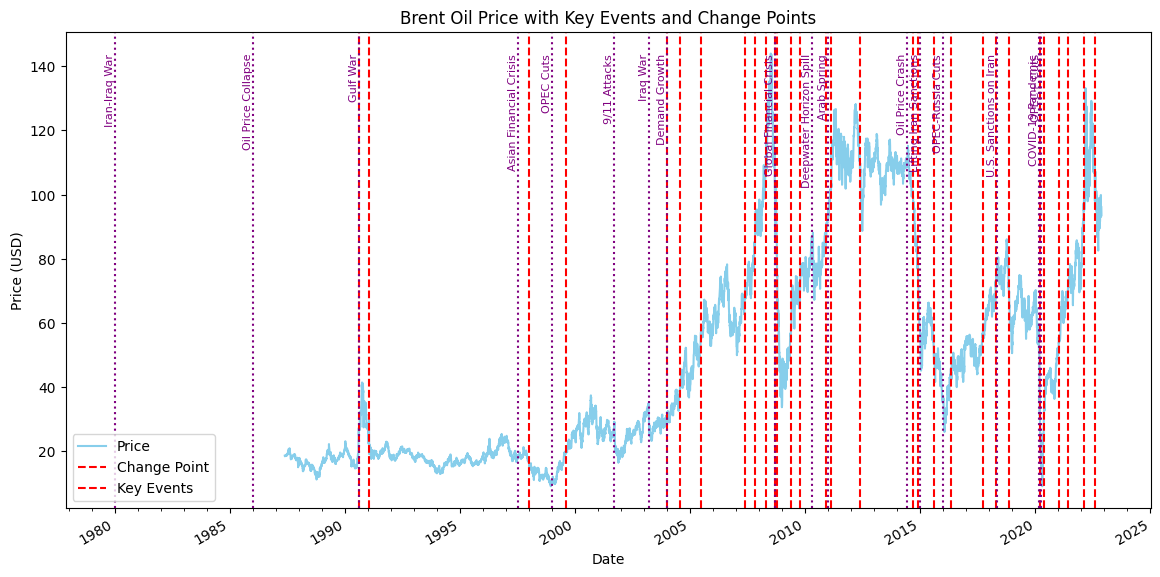

In [29]:
import matplotlib.dates as mdates

# Convert the key events into a dictionary with dates and labels
event_dates = [
    "1980-01-01", "1986-01-01", "1990-08-02", "1997-07-02", "1999-01-01", "2001-09-11",
    "2003-03-20", "2004-01-01", "2008-09-15", "2010-04-20", "2011-01-01", "2014-06-01",
    "2015-01-01", "2016-01-01", "2018-05-08", "2020-03-01", "2020-04-01"
]
event_labels = [
    "Iran-Iraq War", "Oil Price Collapse", "Gulf War", "Asian Financial Crisis", "OPEC Cuts", 
    "9/11 Attacks", "Iraq War", "Demand Growth", "Global Financial Crisis", 
    "Deepwater Horizon Spill", "Arab Spring", "Oil Price Crash", "Lifting Iran Sanctions", 
    "OPEC-Russia Cuts", "U.S. Sanctions on Iran", "COVID-19 Pandemic", "OPEC+ Cuts"
]

# Plot the Brent oil prices and change points
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Price'], label="Brent Oil Price", color="skyblue")

# Mark detected change points
for cp in change_points[:-1]:  # Exclude the last index as it represents the end of the series
    plt.axvline(brent_oil_data.index[cp], color="red", linestyle="--")

# Mark key events with vertical lines and labels
for date, label in zip(event_dates, event_labels):
    plt.axvline(pd.to_datetime(date), color="purple", linestyle=":")
    plt.text(pd.to_datetime(date), brent_oil_data['Price'].max(), label, rotation=90, color="purple", ha='right', va='top', fontsize=8)

# Customizing the plot
plt.title("Brent Oil Price with Key Events and Change Points")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(["Price", "Change Point", "Key Events"])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Major ticks every 5 years
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every 1 year
plt.gcf().autofmt_xdate()  # Rotate date labels for readability

plt.show()


### Stationarity Check

In [30]:
# Define a function to perform the ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

# Run ADF test on the oil price data
print("\nAugmented Dickey-Fuller Test for Stationarity:\n")
adf_test(brent_oil_data['Price'])



Augmented Dickey-Fuller Test for Stationarity:

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
Critical Value 1%: -3.4310783342658615
Critical Value 5%: -2.861861876398633
Critical Value 10%: -2.566941329781918


In [31]:
def test_stationarity(timeseries):
    # Remove any infinite values
    timeseries = timeseries[np.isfinite(timeseries)]
    
    # Remove any NaN values
    timeseries = timeseries.dropna()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Assuming brent_oil_data is your DataFrame
# First, ensure your differencing operation isn't introducing NaNs
brent_oil_data['Price_diff'] = brent_oil_data['Price'].diff().dropna()

# Then test stationarity
test_stationarity(brent_oil_data['Price_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -1.552937e+01
p-value                        2.230741e-28
#Lags Used                     2.800000e+01
Number of Observations Used    8.981000e+03
Critical Value (1%)           -3.431078e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566941e+00
dtype: float64


In [38]:
import pandas as pd

# Load the Brent Oil data
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

# Strip whitespace from column names
brent_oil_data.columns = brent_oil_data.columns.str.strip()

# Display the first few rows and the columns in the DataFrame
print(brent_oil_data.head())
print(brent_oil_data.columns)

# Ensure the date column is converted correctly if it exists
if 'Date' in brent_oil_data.columns:
    brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'], errors='coerce')
else:
    print("Date column not found in the DataFrame.")


        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63
Index(['Date', 'Price'], dtype='object')


Brent Oil Data Sample:
        Date  Price  price_change
0 1987-05-20  18.63           NaN
1 1987-05-21  18.45     -0.966184
2 1987-05-22  18.55      0.542005
3 1987-05-25  18.60      0.269542
4 1987-05-26  18.63      0.161290
Brent Oil Data with Events Marked:
         Date  Price  price_change  event
0  1987-05-20  18.63           NaN      0
1  1987-05-21  18.45     -0.966184      0
2  1987-05-22  18.55      0.542005      0
3  1987-05-25  18.60      0.269542      0
4  1987-05-26  18.63      0.161290      0
5  1987-05-27  18.60     -0.161031      0
6  1987-05-28  18.60      0.000000      0
7  1987-05-29  18.58     -0.107527      0
8  1987-06-01  18.65      0.376749      0
9  1987-06-02  18.68      0.160858      0
10 1987-06-03  18.75      0.374732      0
11 1987-06-04  18.78      0.160000      0
12 1987-06-05  18.65     -0.692226      0
13 1987-06-08  18.75      0.536193      0
14 1987-06-09  18.78      0.160000      0
15 1987-06-10  18.78      0.000000      0
16 1987-06-11  18.68    

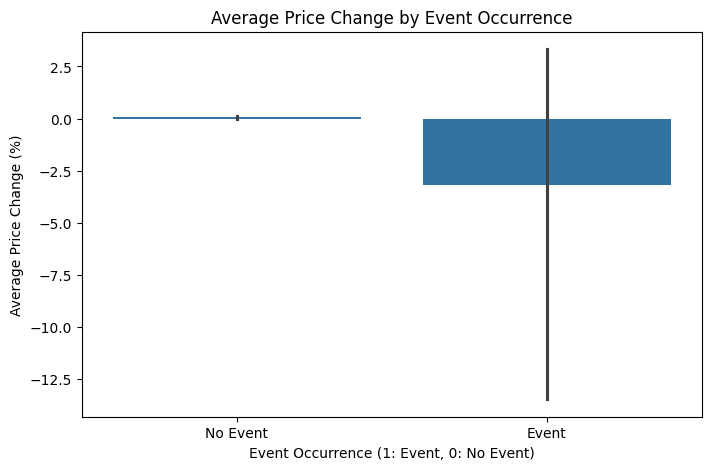

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compile Key Events
key_events_data = {
    'event': [
        "Iran-Iraq War", "Oil Price Collapse", "Gulf War", 
        "Asian Financial Crisis", "OPEC Production Cuts", 
        "9/11 Attacks", "Iraq War", "Demand Growth", 
        "Global Financial Crisis", "Deepwater Horizon Spill", 
        "Arab Spring", "Oil Price Crash", 
        "Lifting of Iran Sanctions", "OPEC-Russia Cuts", 
        "U.S. Sanctions on Iran", "COVID-19 Pandemic", 
        "OPEC+ Production Cuts"
    ],
    'date': pd.to_datetime([
        "1980-01-01", "1986-01-01", "1990-01-01",
        "1997-01-01", "1999-01-01", "2001-09-11",
        "2003-03-20", "2004-01-01", "2008-01-01",
        "2010-04-20", "2011-01-01", "2014-01-01",
        "2015-01-01", "2016-01-01", "2018-01-01",
        "2020-01-01", "2020-04-01"
    ])
}

events_data = pd.DataFrame(key_events_data)

# Load the Brent Oil data
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

# Ensure 'Date' is in datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Example of price change calculation
brent_oil_data['price_change'] = brent_oil_data['Price'].pct_change() * 100  # Percentage change

# Print a sample of the data for debugging
print("Brent Oil Data Sample:")
print(brent_oil_data.head())

# Merge Events with Price Changes
brent_oil_data['event'] = 0  # Initialize with 0 (no event)

# Set event to 1 for rows that match the event dates
for idx, row in events_data.iterrows():
    brent_oil_data.loc[brent_oil_data['Date'] == row['date'], 'event'] = 1  # Only mark the event day

# Print a sample of the data to check event marking
print("Brent Oil Data with Events Marked:")
print(brent_oil_data[['Date', 'Price', 'price_change', 'event']].head(20))

# Analyze Correlation
# Create a correlation DataFrame
correlation_data = brent_oil_data[['price_change', 'event']].copy()

# Print the correlation data before calculating correlation
print("Correlation Data Sample:")
print(correlation_data)

# Calculate correlation
correlation_matrix = correlation_data.corr()

# Print the correlation matrix
print("Correlation between Events and Price Changes:")
print(correlation_matrix)

# Visualize Results
plt.figure(figsize=(8, 5))
sns.barplot(x='event', y='price_change', data=correlation_data, estimator=np.mean)
plt.title('Average Price Change by Event Occurrence')
plt.xlabel('Event Occurrence (1: Event, 0: No Event)')
plt.ylabel('Average Price Change (%)')
plt.xticks(ticks=[0, 1], labels=['No Event', 'Event'])
plt.show()


In [42]:
print(events_data)

                        event       date
0               Iran-Iraq War 1980-01-01
1          Oil Price Collapse 1986-01-01
2                    Gulf War 1990-01-01
3      Asian Financial Crisis 1997-01-01
4        OPEC Production Cuts 1999-01-01
5                9/11 Attacks 2001-09-11
6                    Iraq War 2003-03-20
7               Demand Growth 2004-01-01
8     Global Financial Crisis 2008-01-01
9     Deepwater Horizon Spill 2010-04-20
10                Arab Spring 2011-01-01
11            Oil Price Crash 2014-01-01
12  Lifting of Iran Sanctions 2015-01-01
13           OPEC-Russia Cuts 2016-01-01
14     U.S. Sanctions on Iran 2018-01-01
15          COVID-19 Pandemic 2020-01-01
16      OPEC+ Production Cuts 2020-04-01


In [46]:
# Convert Date columns to datetime if not already
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])
events_data['date'] = pd.to_datetime(events_data['date'])  # Adjust as necessary


In [49]:
# Initialize event column
brent_oil_data['event'] = 0  

# Loop through each event date to mark them in brent_oil_data
for event_date in events_data['date']:
    print(f"Checking for event date: {event_date}")  # Debug print
    matching_rows = brent_oil_data.loc[brent_oil_data['Date'] == event_date]
    if not matching_rows.empty:
        print(f"Found matching rows for date: {event_date}")  # Debug print
        brent_oil_data.loc[brent_oil_data['Date'] == event_date, 'event'] = 1
    else:
        print(f"No match for date: {event_date}")  # Debug print

# Display the updated DataFrame
print(brent_oil_data.head(20))  # Check the first 20 rows


Checking for event date: 1980-01-01 00:00:00
No match for date: 1980-01-01 00:00:00
Checking for event date: 1986-01-01 00:00:00
No match for date: 1986-01-01 00:00:00
Checking for event date: 1990-01-01 00:00:00
No match for date: 1990-01-01 00:00:00
Checking for event date: 1997-01-01 00:00:00
No match for date: 1997-01-01 00:00:00
Checking for event date: 1999-01-01 00:00:00
No match for date: 1999-01-01 00:00:00
Checking for event date: 2001-09-11 00:00:00
Found matching rows for date: 2001-09-11 00:00:00
Checking for event date: 2003-03-20 00:00:00
Found matching rows for date: 2003-03-20 00:00:00
Checking for event date: 2004-01-01 00:00:00
No match for date: 2004-01-01 00:00:00
Checking for event date: 2008-01-01 00:00:00
No match for date: 2008-01-01 00:00:00
Checking for event date: 2010-04-20 00:00:00
Found matching rows for date: 2010-04-20 00:00:00
Checking for event date: 2011-01-01 00:00:00
No match for date: 2011-01-01 00:00:00
Checking for event date: 2014-01-01 00:00:0

In [50]:
# Calculate and print correlation
correlation = brent_oil_data[['price_change', 'event']].corr()
print("Correlation between Events and Price Changes:")
print(correlation)


Correlation between Events and Price Changes:
              price_change     event
price_change      1.000000 -0.030102
event            -0.030102  1.000000


In [48]:
# Recalculate correlation
correlation = brent_oil_data[['price_change', 'event']].corr()
print("Correlation between Events and Price Changes:")
print(correlation)


Correlation between Events and Price Changes:
              price_change     event
price_change      1.000000 -0.030102
event            -0.030102  1.000000


In [51]:
print("Date Range of brent_oil_data:")
print(brent_oil_data['Date'].min(), "to", brent_oil_data['Date'].max())


Date Range of brent_oil_data:
1987-05-20 00:00:00 to 2022-11-14 00:00:00


In [52]:
unmatched_dates = []
for event_date in events_data['date']:
    if brent_oil_data.loc[brent_oil_data['Date'] == event_date].empty:
        unmatched_dates.append(event_date)

print("Unmatched event dates:")
print(unmatched_dates)


Unmatched event dates:
[Timestamp('1980-01-01 00:00:00'), Timestamp('1986-01-01 00:00:00'), Timestamp('1990-01-01 00:00:00'), Timestamp('1997-01-01 00:00:00'), Timestamp('1999-01-01 00:00:00'), Timestamp('2004-01-01 00:00:00'), Timestamp('2008-01-01 00:00:00'), Timestamp('2011-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00')]


In [55]:
# Example of resampling to monthly averages
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])
monthly_data = brent_oil_data.resample('M', on='Date').mean().reset_index()


In [56]:
# Create a list of matched event dates
matched_event_dates = [
    pd.Timestamp('2001-09-11'),
    pd.Timestamp('2003-03-20'),
    pd.Timestamp('2010-04-20'),
    pd.Timestamp('2020-01-01'),
    pd.Timestamp('2020-04-01'),
]

# Filter events_data to only include matched dates
filtered_events_data = events_data[events_data['date'].isin(matched_event_dates)]
print(filtered_events_data)


                      event       date
5              9/11 Attacks 2001-09-11
6                  Iraq War 2003-03-20
9   Deepwater Horizon Spill 2010-04-20
15        COVID-19 Pandemic 2020-01-01
16    OPEC+ Production Cuts 2020-04-01


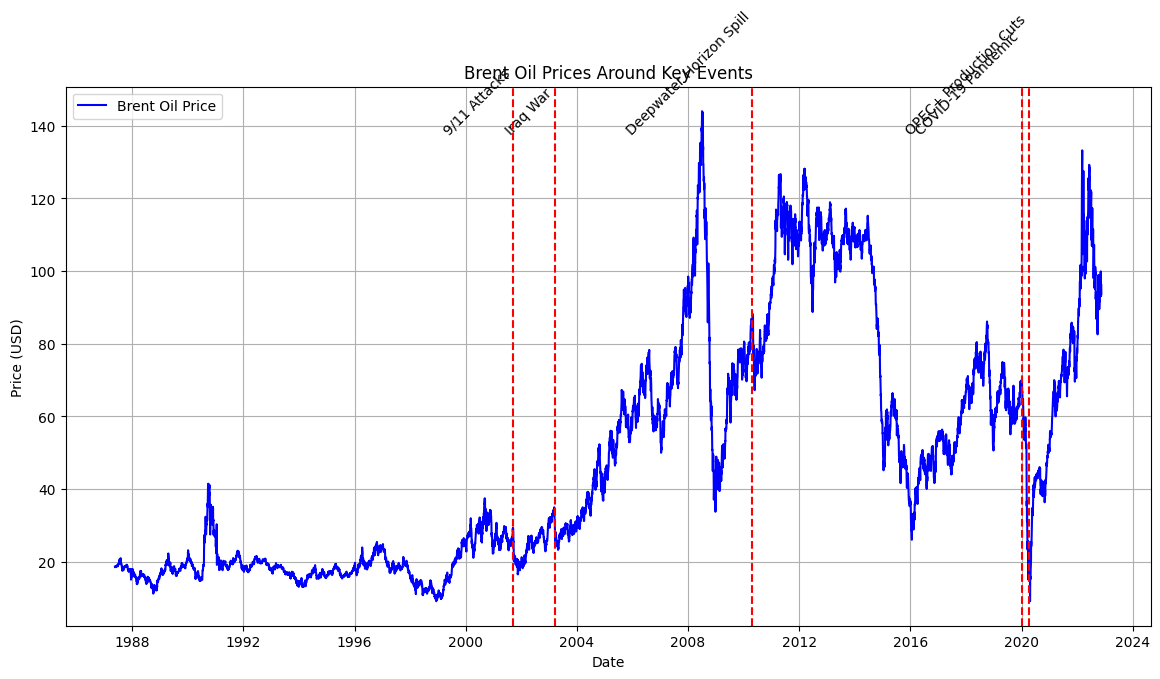

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'date' column to datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Set the Date as the index for easy plotting
brent_oil_data.set_index('Date', inplace=True)

# List of event dates for visualization
event_dates = [
    pd.Timestamp('2001-09-11'),
    pd.Timestamp('2003-03-20'),
    pd.Timestamp('2010-04-20'),
    pd.Timestamp('2020-01-01'),
    pd.Timestamp('2020-04-01'),
]

# Plot the price data
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data.index, brent_oil_data['Price'], label='Brent Oil Price', color='blue')

# Mark event dates
for event_date in event_dates:
    plt.axvline(x=event_date, color='red', linestyle='--')

# Annotate events on the plot
event_labels = [
    '9/11 Attacks',
    'Iraq War',
    'Deepwater Horizon Spill',
    'COVID-19 Pandemic',
    'OPEC+ Production Cuts'
]
for event_date, label in zip(event_dates, event_labels):
    plt.text(event_date, brent_oil_data['Price'].max()*0.95, label, rotation=45, verticalalignment='bottom', horizontalalignment='right')

plt.title('Brent Oil Prices Around Key Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [69]:
import pandas as pd

# Load your dataset
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv') # Replace with your actual file path

# Ensure 'Date' column is in datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])  # Adjust 'Date' if your column has a different name

# Assuming there is a 'price_change' column in your dataset
# Create a price change column if necessary
brent_oil_data['price_change'] = brent_oil_data['Price'].diff()  # Calculate price changes (if you have a 'Price' column)


In [70]:
from scipy import stats
# Define the function for analyzing event impact
def analyze_event_impact(brent_oil_data, event_dates):
    results = []
    
    for event in event_dates:
        # Define the time window (30 days before and after)
        start_date = event - pd.Timedelta(days=30)
        end_date = event + pd.Timedelta(days=30)
        
        # Filter the DataFrame for the relevant time frame
        window_data = brent_oil_data[(brent_oil_data['Date'] >= start_date) & (brent_oil_data['Date'] <= end_date)]
        
        # Perform T-Test: compare price changes before and after the event
        before_event = window_data[window_data['Date'] < event]['price_change']
        after_event = window_data[window_data['Date'] >= event]['price_change']
        
        if len(before_event) > 1 and len(after_event) > 1:  # Ensure enough data for T-test
            t_stat, p_val = stats.ttest_ind(before_event.dropna(), after_event.dropna(), equal_var=False)
            results.append({'event': event, 't_statistic': t_stat, 'p_value': p_val})
    
    return pd.DataFrame(results)

# Example usage
event_dates = pd.to_datetime(['2001-09-11', '2003-03-20', '2010-04-20', '2020-01-01', '2020-04-01'])
results_df = analyze_event_impact(brent_oil_data, event_dates)
print(results_df)


       event  t_statistic   p_value
0 2001-09-11     1.330662  0.194324
1 2003-03-20    -0.359306  0.721182
2 2010-04-20     1.580308  0.121797
3 2020-01-01     1.847427  0.071720
4 2020-04-01    -1.507527  0.139520


                  Date     Price  price_change
Date          1.000000  0.720816      0.002402
Price         0.720816  1.000000      0.020107
price_change  0.002402  0.020107      1.000000


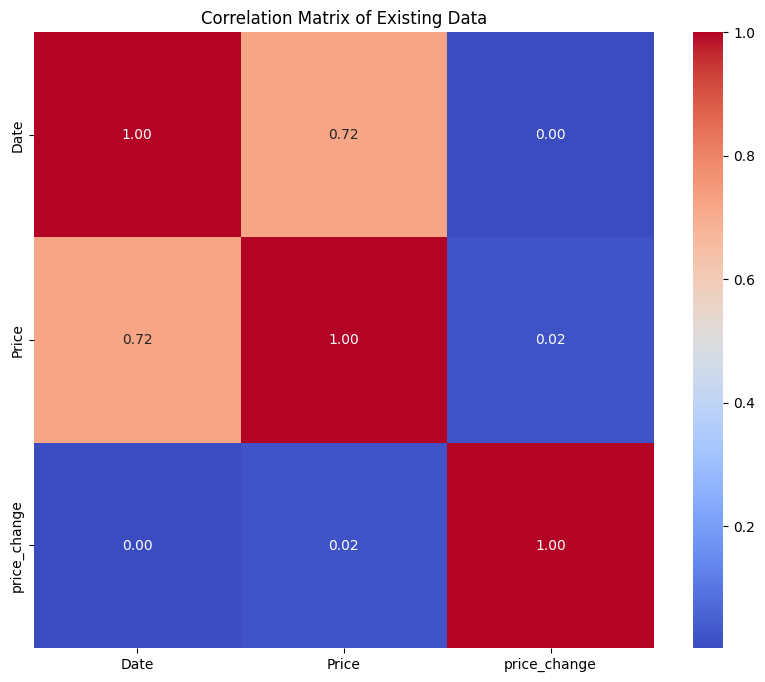

In [71]:
# Perform correlation analysis on the existing DataFrame
correlation_matrix = brent_oil_data.corr()
print(correlation_matrix)

# Optional: Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Existing Data')
plt.show()


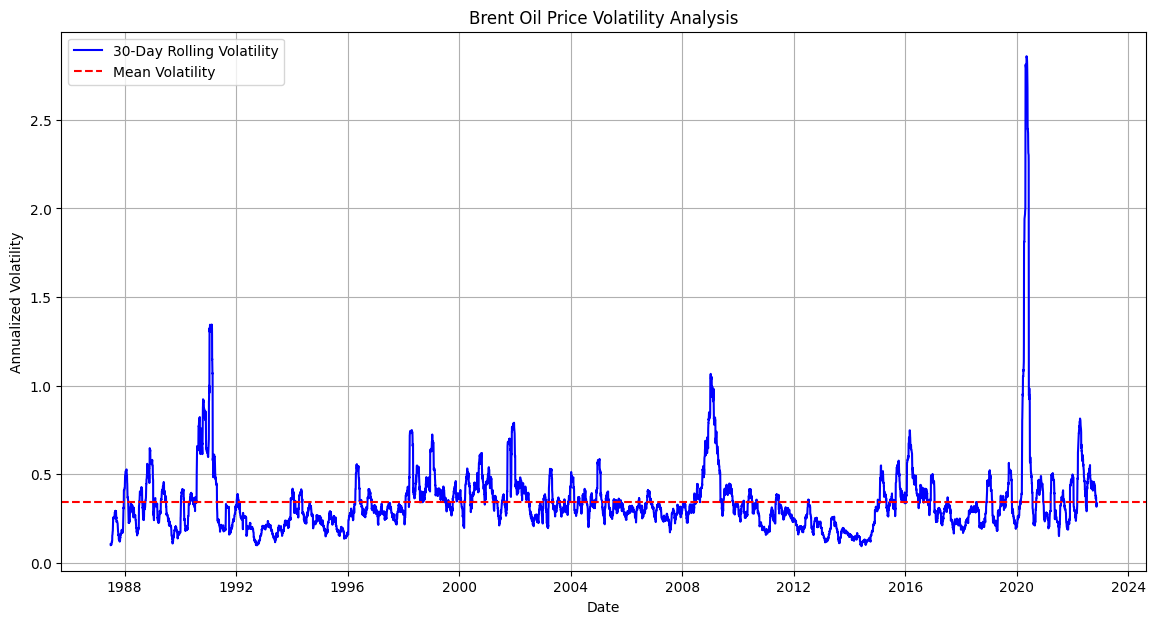

In [72]:
# Assume brent_oil_data is your DataFrame and has a 'Price' column with daily closing prices
# First, ensure the 'Date' column is in datetime format and set as the index
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])
brent_oil_data.set_index('Date', inplace=True)

# Calculate Daily Returns
brent_oil_data['Daily_Return'] = brent_oil_data['Price'].pct_change()

# Calculate Volatility
# Using rolling window for volatility calculation (e.g., 30-day rolling window)
rolling_window = 30
brent_oil_data['Volatility'] = brent_oil_data['Daily_Return'].rolling(window=rolling_window).std() * np.sqrt(252)  # Annualizing the volatility

# Visualize Volatility
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Volatility'], label=f'{rolling_window}-Day Rolling Volatility', color='blue')
plt.title('Brent Oil Price Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.axhline(y=brent_oil_data['Volatility'].mean(), color='red', linestyle='--', label='Mean Volatility')
plt.legend()
plt.grid()
plt.show()


Identified Extreme Events:
Empty DataFrame
Columns: [Date, Price]
Index: []


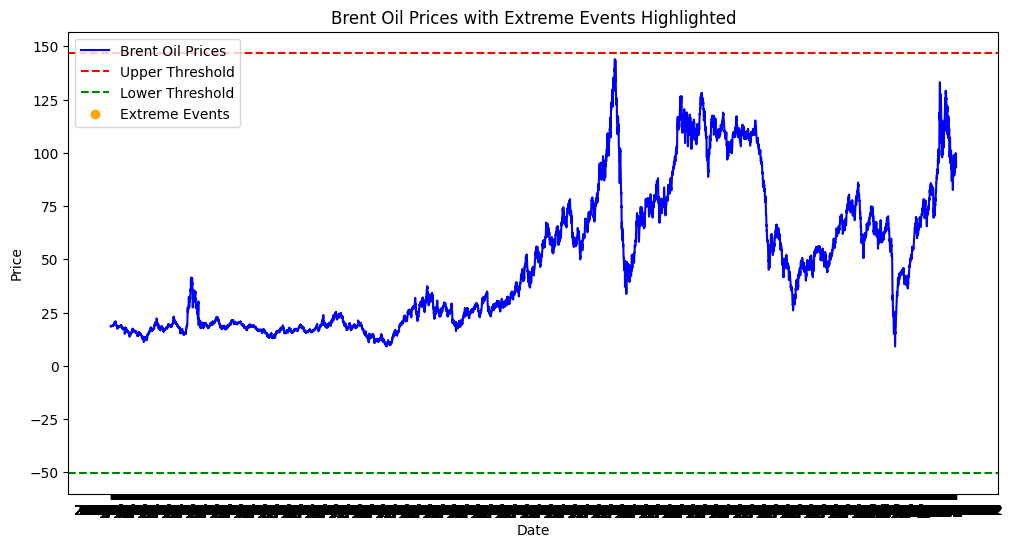

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')


# Example data for demonstration (uncomment the above line)
# brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Calculate mean and standard deviation
mean_price = brent_oil_data['Price'].mean()
std_price = brent_oil_data['Price'].std()

# Define thresholds for extreme events
threshold_upper = mean_price + 3 * std_price
threshold_lower = mean_price - 3 * std_price

# Identify extreme events
extreme_events = brent_oil_data[(brent_oil_data['Price'] > threshold_upper) | 
                                 (brent_oil_data['Price'] < threshold_lower)]

# Print extreme events
print("Identified Extreme Events:")
print(extreme_events)

# Visualize the Brent oil prices with extreme events highlighted
plt.figure(figsize=(12, 6))
plt.plot(brent_oil_data['Date'], brent_oil_data['Price'], label='Brent Oil Prices', color='blue')
plt.axhline(threshold_upper, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(threshold_lower, color='green', linestyle='--', label='Lower Threshold')
plt.scatter(extreme_events['Date'], extreme_events['Price'], color='orange', label='Extreme Events', zorder=5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Brent Oil Prices with Extreme Events Highlighted')
plt.legend()
plt.show()


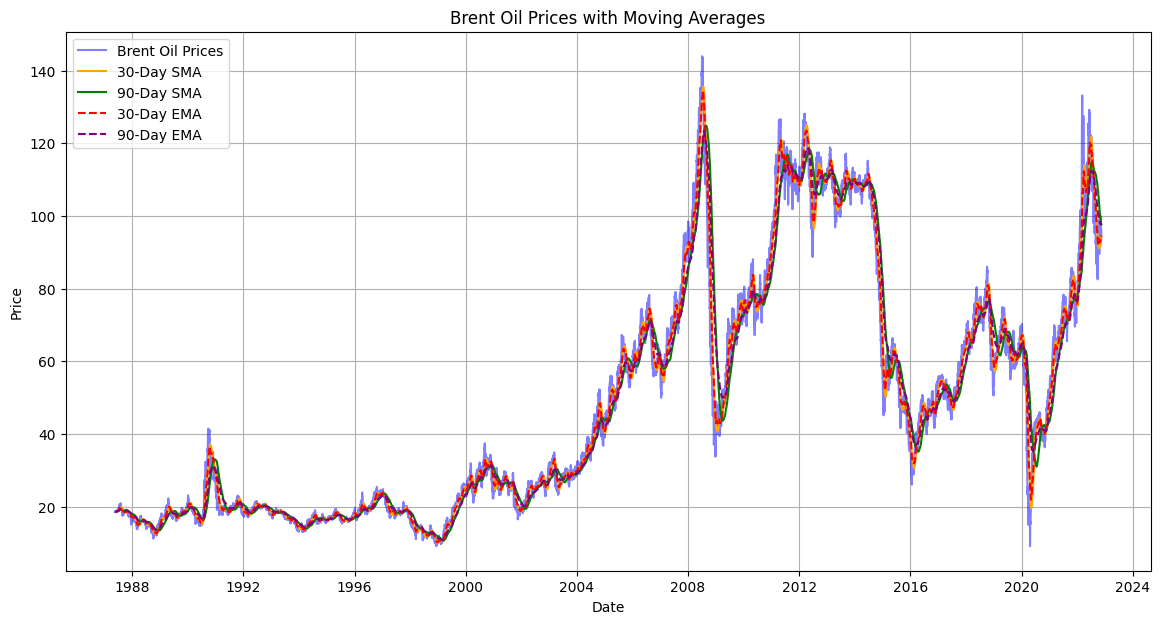

In [76]:
# Ensure the 'Date' column is in datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Set 'Date' as the DataFrame index
brent_oil_data.set_index('Date', inplace=True)

# Calculate Moving Averages
# Adjust the window sizes as needed (e.g., 30 days and 90 days)
short_window = 30  # Short-term moving average
long_window = 90   # Long-term moving average

# Simple Moving Average (SMA)
brent_oil_data['SMA_30'] = brent_oil_data['Price'].rolling(window=short_window).mean()
brent_oil_data['SMA_90'] = brent_oil_data['Price'].rolling(window=long_window).mean()

# Exponential Moving Average (EMA)
brent_oil_data['EMA_30'] = brent_oil_data['Price'].ewm(span=short_window, adjust=False).mean()
brent_oil_data['EMA_90'] = brent_oil_data['Price'].ewm(span=long_window, adjust=False).mean()

# Visualize the original data and moving averages
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Price'], label='Brent Oil Prices', color='blue', alpha=0.5)
plt.plot(brent_oil_data['SMA_30'], label='30-Day SMA', color='orange')
plt.plot(brent_oil_data['SMA_90'], label='90-Day SMA', color='green')
plt.plot(brent_oil_data['EMA_30'], label='30-Day EMA', color='red', linestyle='--')
plt.plot(brent_oil_data['EMA_90'], label='90-Day EMA', color='purple', linestyle='--')

# Add titles and labels
plt.title('Brent Oil Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


         Date  Mean Price  Median Price  Max Price  Min Price
0  1987-12-31   18.525813        18.600      20.95      15.03
1  1988-12-31   14.905412        15.130      17.95      11.20
2  1989-12-31   18.228228        18.100      22.25      16.05
3  1990-12-31   23.761445        20.565      41.45      14.68
4  1991-12-31   20.041128        19.700      30.28      17.60
5  1992-12-31   19.319728        19.480      21.55      17.05
6  1993-12-31   17.013413        17.000      19.60      13.13
7  1994-12-31   15.856389        16.065      19.03      13.00
8  1995-12-31   17.015850        16.850      19.38      15.35
9  1996-12-31   20.639803        20.050      25.40      16.23
10 1997-12-31   19.108508        18.830      24.83      15.86
11 1998-12-31   12.758103        12.610      16.28       9.10
12 1999-12-31   17.901566        17.550      26.46       9.77
13 2000-12-31   28.660672        28.860      37.43      21.05
14 2001-12-31   24.455720        25.440      30.68      16.51
15 2002-

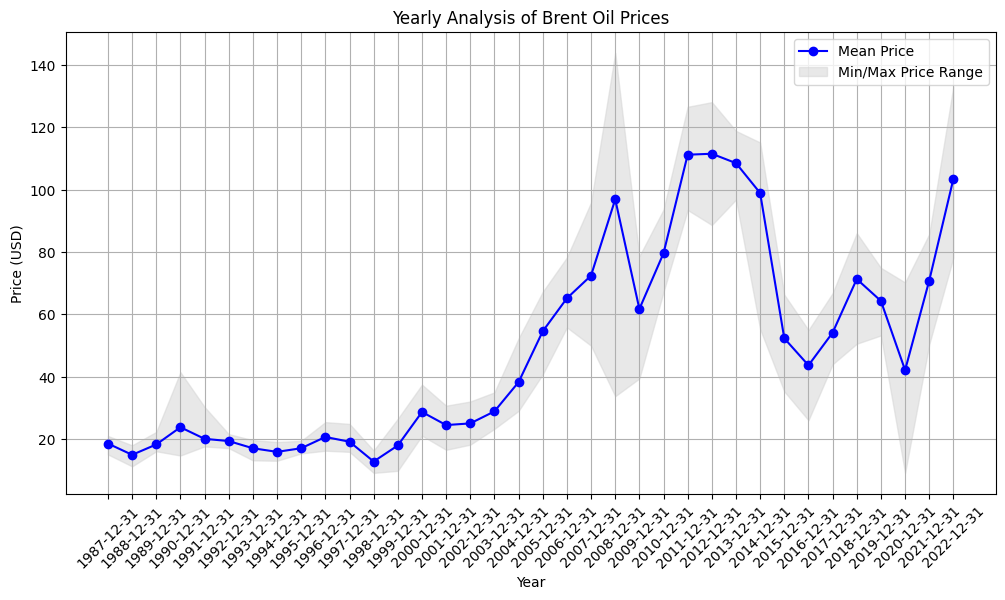

In [77]:
# Aggregate data by year
yearly_data = brent_oil_data.resample('Y').agg({
    'Price': ['mean', 'median', 'max', 'min'],
})

# Rename the columns for easier access
yearly_data.columns = ['Mean Price', 'Median Price', 'Max Price', 'Min Price']
yearly_data.reset_index(inplace=True)

# Print the yearly aggregated data
print(yearly_data)

# Visualize Yearly Trends
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['Date'], yearly_data['Mean Price'], marker='o', label='Mean Price', color='blue')
plt.fill_between(yearly_data['Date'], yearly_data['Min Price'], yearly_data['Max Price'], color='lightgray', alpha=0.5, label='Min/Max Price Range')
plt.title('Yearly Analysis of Brent Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.xticks(yearly_data['Date'], rotation=45)
plt.legend()
plt.grid()
plt.show()


   Month_Name      Price
0     January  46.115007
1    February  46.975216
2       March  48.370495
3       April  48.795262
4         May  50.071047
5        June  49.656970
6        July  49.879719
7      August  50.008715
8   September  48.953819
9     October  49.264025
10   November  46.867992
11   December  45.609861


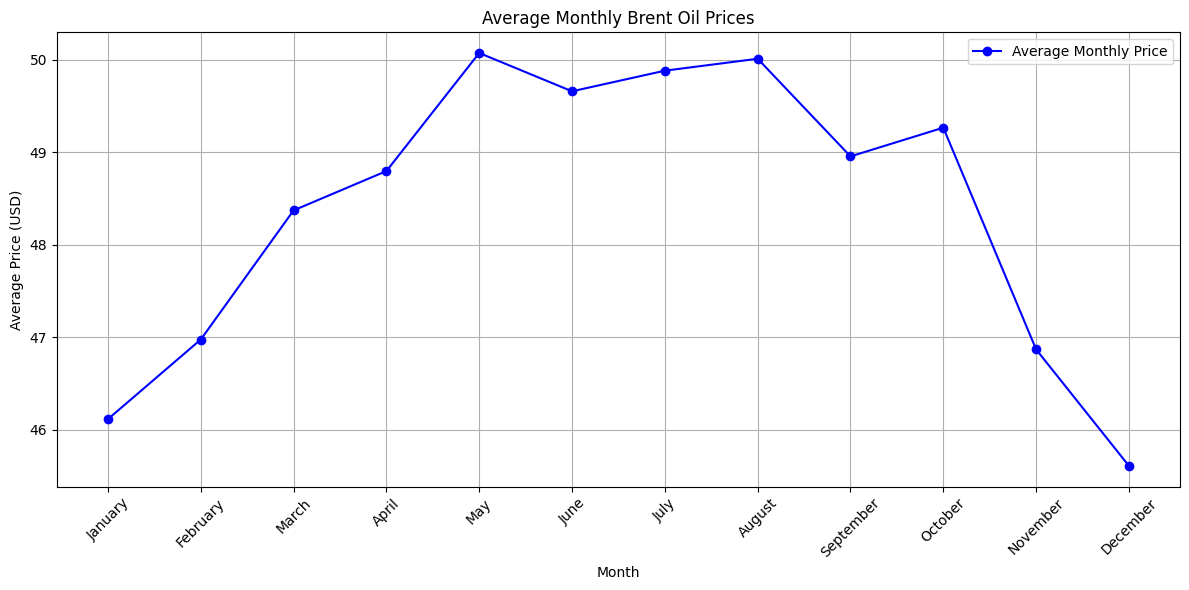

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

# Ensure the 'Date' column is in datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Set 'Date' as the DataFrame index
brent_oil_data.set_index('Date', inplace=True)

# Extract month and year for seasonal analysis
brent_oil_data['Month'] = brent_oil_data.index.month
brent_oil_data['Year'] = brent_oil_data.index.year

# Calculate average prices by month
monthly_average = brent_oil_data.groupby('Month')['Price'].mean().reset_index()

# Map month numbers to month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

monthly_average['Month_Name'] = monthly_average['Month'].map(month_names)

# Sort by month
monthly_average.sort_values('Month', inplace=True)

# Print the monthly average prices
print(monthly_average[['Month_Name', 'Price']])

# Visualize Monthly Trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_average['Month_Name'], monthly_average['Price'], marker='o', label='Average Monthly Price', color='blue')
plt.title('Average Monthly Brent Oil Prices')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Price Range Analysis:
Minimum Price: 9.10
Maximum Price: 143.95
Mean Price: 48.42
Standard Deviation: 32.86


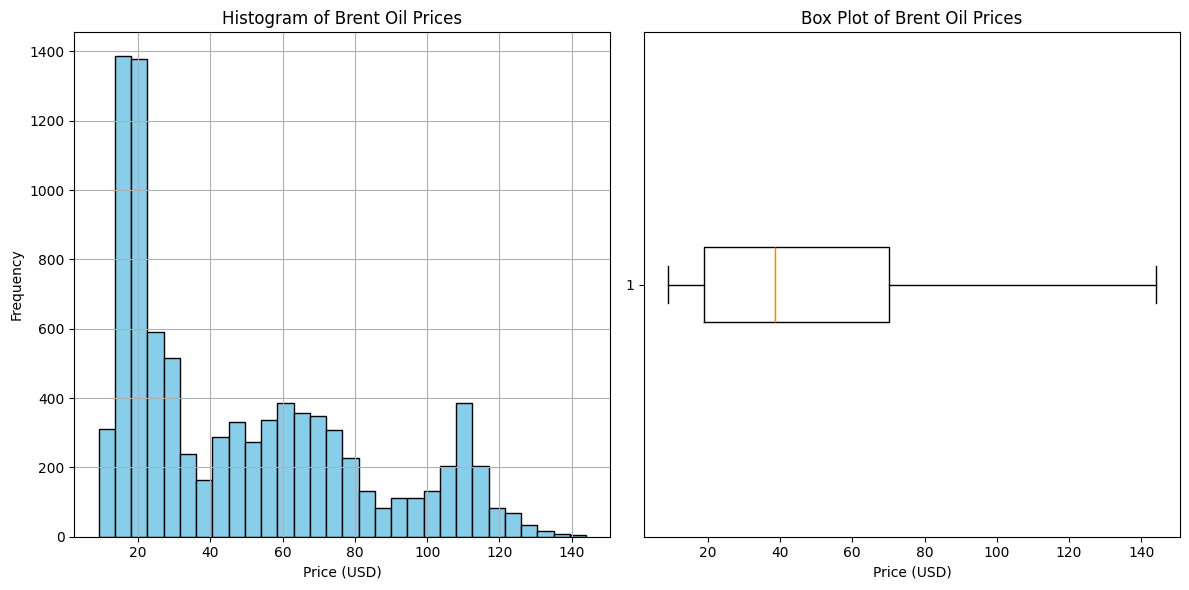

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

# Ensure the 'Date' column is in datetime format
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

# Set 'Date' as the DataFrame index
brent_oil_data.set_index('Date', inplace=True)

# Basic Price Statistics
price_stats = {
    'Minimum Price': brent_oil_data['Price'].min(),
    'Maximum Price': brent_oil_data['Price'].max(),
    'Mean Price': brent_oil_data['Price'].mean(),
    'Standard Deviation': brent_oil_data['Price'].std(),
}

print("Price Range Analysis:")
for stat, value in price_stats.items():
    print(f"{stat}: {value:.2f}")

# Visualization: Price Distribution
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(brent_oil_data['Price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Brent Oil Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid()

# Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(brent_oil_data['Price'], vert=False)
plt.title('Box Plot of Brent Oil Prices')
plt.xlabel('Price (USD)')

plt.tight_layout()
plt.show()


### Model Building and Evaluation

RMSE: 24.833934902765257
MAE: 18.484341205477442
R-squared: -0.4485183026725954


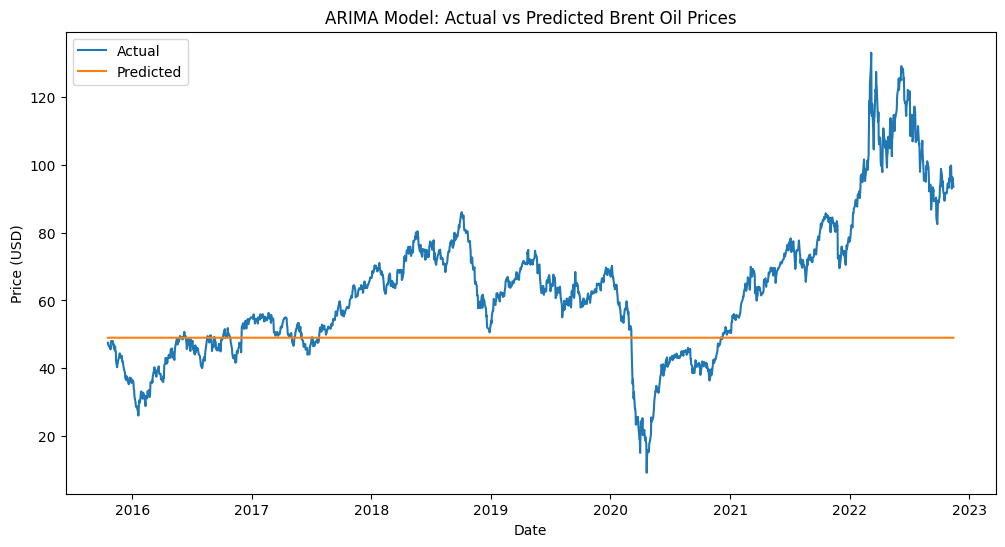

In [85]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the data into train and test sets
train_data = brent_oil_data['Price'][:int(0.8*len(brent_oil_data))]
test_data = brent_oil_data['Price'][int(0.8*len(brent_oil_data)):]

# Fit ARIMA model
model = ARIMA(train_data, order=(1,1,1))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.title('ARIMA Model: Actual vs Predicted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3449228.415784071
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1045309.535658939
Iteration:      3,   Func. Count:     19,   Neg. LLF: 38797.22979007702
Iteration:      4,   Func. Count:     26,   Neg. LLF: 29938.792638755283
Iteration:      5,   Func. Count:     32,   Neg. LLF: 30510.923258258983
Iteration:      6,   Func. Count:     38,   Neg. LLF: 27964.560819876355
Iteration:      7,   Func. Count:     43,   Neg. LLF: 27954.345581189
Iteration:      8,   Func. Count:     49,   Neg. LLF: 26769.253173293557
Iteration:      9,   Func. Count:     54,   Neg. LLF: 26656.36779426311
Iteration:     10,   Func. Count:     59,   Neg. LLF: 37537.11061270586
Iteration:     11,   Func. Count:     67,   Neg. LLF: 30964.564352494737
Iteration:     12,   Func. Count:     73,   Neg. LLF: 26010.49393036366
Iteration:     13,   Func. Count:     78,   Neg. LLF: 26500.2200008754
Iteration:     14,   Func. Count:     86,   Neg. LLF: 25997.27

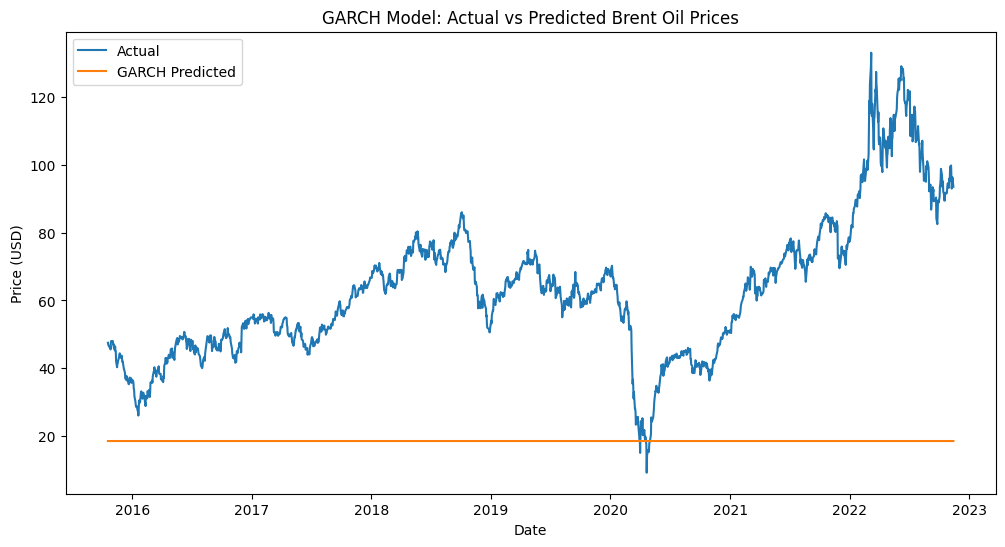

In [87]:
from arch import arch_model

# Fit GARCH model
garch_model = arch_model(train_data, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit()

# Make predictions
garch_forecast = garch_results.forecast(horizon=len(test_data))
garch_predictions = garch_forecast.mean.iloc[-1]

# Evaluate GARCH model
garch_mse = mean_squared_error(test_data, garch_predictions)
garch_rmse = math.sqrt(garch_mse)
garch_mae = mean_absolute_error(test_data, garch_predictions)
garch_r2 = r2_score(test_data, garch_predictions)

print(f"GARCH RMSE: {garch_rmse}")
print(f"GARCH MAE: {garch_mae}")
print(f"GARCH R-squared: {garch_r2}")

# Plot GARCH results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, garch_predictions, label='GARCH Predicted')
plt.title('GARCH Model: Actual vs Predicted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

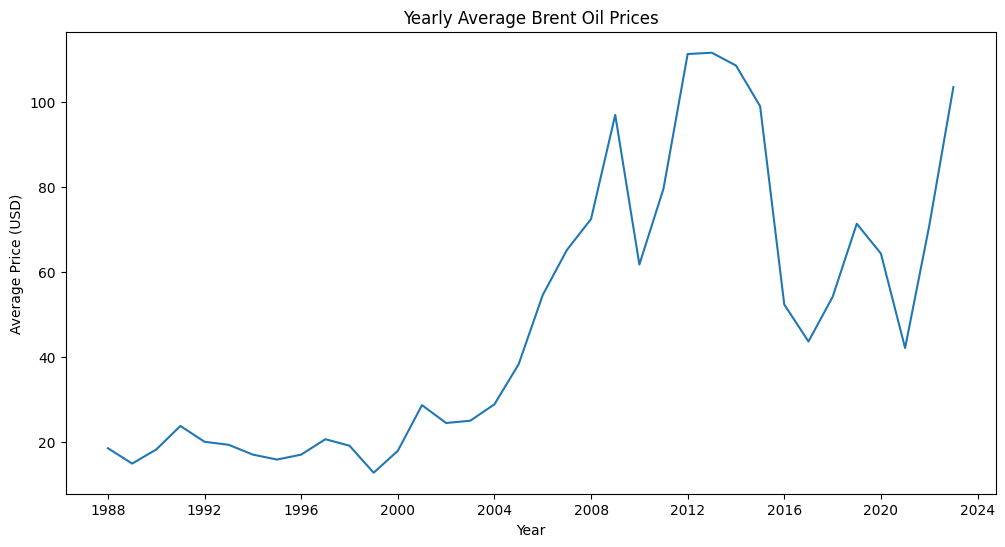

In [89]:
# Visualize yearly average prices
yearly_avg = brent_oil_data.resample('Y').mean()
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg.index, yearly_avg['Price'])
plt.title('Yearly Average Brent Oil Prices')
plt.xlabel('Year')
plt.ylabel('Average Price (USD)')
plt.show()

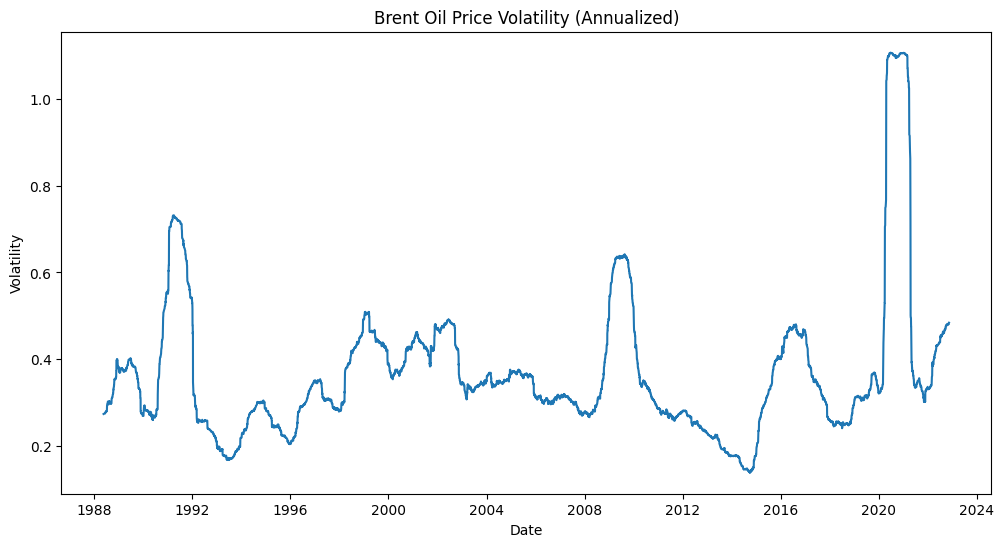

In [90]:
# Visualize volatility over time
brent_oil_data['Returns'] = brent_oil_data['Price'].pct_change()
volatility = brent_oil_data['Returns'].rolling(window=252).std() * np.sqrt(252)
plt.figure(figsize=(12, 6))
plt.plot(volatility.index, volatility)
plt.title('Brent Oil Price Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()